<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/est_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Date: 2025-08-08
Close: 269.85
Regime: TREND_UP (score=0.58)
Signals: ADX_pct=0.45, BBWidth_pct=0.50, R2=0.65, EMAslope_abs_pct=0.63, KalmanSlope_abs_pct=0.54, ATR_pct_pct=0.00, DI_gap_pct=0.70
Impulse: GREEN (supports trend)
Saved plot to regime_plot.png


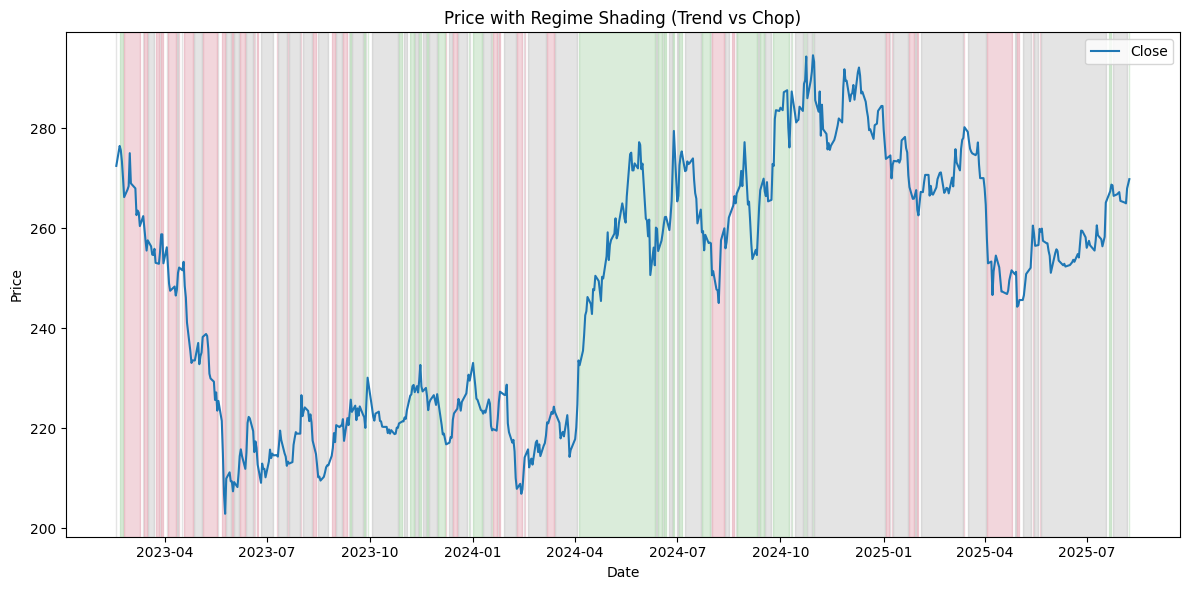

In [17]:
"""
Nifty Regime Classifier — Trend vs Chop
=======================================

What this does
--------------
- Computes multiple regime signals (ADX, BB Width, EMA slope, rolling R^2, ATR%, Elder Impulse, Kalman slope).
- Normalizes signals to 0–1, fuses them into a **regime score** (trendiness) and **direction** (up/down).
- Labels each day as **TREND_UP**, **TREND_DOWN**, or **CHOP**.
- Produces quick summary of the **latest** regime with contributing factors.
- Optional plot with background shading by regime.

Input
-----
CSV with columns (case-insensitive): Date, Close. If available, also use Open, High, Low.
Date will be parsed automatically. If High/Low missing, ADX falls back to NaN and
is ignored in the fusion (weights auto-renormalize on non-NaN signals).

Quick start
-----------
1) Put your CSV path in `CSV_PATH`.
2) Run the script.
3) See the last line printed and the saved plot `regime_plot.png`.

Advanced
--------
- Adjust lookbacks & weights in the `Config` dataclass.
- Use `classify_regime(df, cfg)` in your own notebooks/pipelines.
"""

from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Dict, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Config & Utilities
# -----------------------------

@dataclass
class Config:
    # core windows
    adx_len: int = 14
    ema_fast: int = 20
    ema_slow: int = 50
    rreg_win: int = 20  # rolling regression window (trending horizon)
    bb_win: int = 20
    atr_len: int = 14
    kalman_qr: float = 0.05  # responsiveness of Kalman (higher=faster)

    # normalization window for percent ranks (trendiness context)
    norm_win: int = 252

    # fusion weights (sum doesn't need to be 1; we renormalize after NaN drops)
    weights: Dict[str, float] = None

    # classification thresholds
    trend_lo: float = 0.55  # >= TREND if score ≥ trend_lo
    trend_hi: float = 0.65  # STRONG trend if score ≥ trend_hi (used for plotting emphasis)

    def __post_init__(self):
        if self.weights is None:
            self.weights = {
                'ADX_pct': 1.2,           # higher = trendlier
                'BBWidth_pct': 0.8,       # higher = expanding range (post-squeeze trend)
                'R2': 1.0,                # higher = cleaner trend
                'EMAslope_abs_pct': 1.0,  # slope magnitude
                'ATR_pct': 0.4,           # higher = movement (helps escape chop)
                'KalmanSlope_abs_pct': 0.8,
                'Impulse_trend': 0.6,     # 1 if green/red, 0 if blue
                'DI_gap_pct': 0.8,        # |+DI - -DI| percentile
            }

# --------------
# Safe helpers
# --------------

def _to_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s.astype(str).str.replace(',', ''), errors='coerce')


def _ema(s: pd.Series, span: int) -> pd.Series:
    return s.ewm(span=span, adjust=False).mean()


def _atr(df: pd.DataFrame, length: int = 14) -> pd.Series:
    if not set(['high','low','close']).issubset({c.lower() for c in df.columns}):
        return pd.Series(np.nan, index=df.index)
    h = df['high'] if 'high' in df.columns else df['High']
    l = df['low'] if 'low' in df.columns else df['Low']
    c = df['close'] if 'close' in df.columns else df['Close']
    prev_c = c.shift(1)
    tr = pd.concat([(h - l).abs(), (h - prev_c).abs(), (l - prev_c).abs()], axis=1).max(axis=1)
    atr = tr.ewm(alpha=1/length, adjust=False).mean()
    return atr


def _adx(df: pd.DataFrame, length: int = 14) -> pd.DataFrame:
    # Returns ADX, +DI, -DI
    cols = {c.lower(): c for c in df.columns}
    if not all(k in cols for k in ['high','low','close']):
        idx = df.index
        return pd.DataFrame({'ADX': np.nan, '+DI': np.nan, '-DI': np.nan}, index=idx)
    H = df[cols['high']].astype(float)
    L = df[cols['low']].astype(float)
    C = df[cols['close']].astype(float)

    up_move = H.diff()
    down_move = -L.diff()
    plus_dm = up_move.where((up_move > down_move) & (up_move > 0), 0.0)
    minus_dm = down_move.where((down_move > up_move) & (down_move > 0), 0.0)

    tr1 = (H - L).abs()
    tr2 = (H - C.shift()).abs()
    tr3 = (L - C.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    atr = tr.ewm(alpha=1/length, adjust=False).mean()
    plus_di = 100 * (plus_dm.ewm(alpha=1/length, adjust=False).mean() / atr)
    minus_di = 100 * (minus_dm.ewm(alpha=1/length, adjust=False).mean() / atr)

    dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
    adx = dx.ewm(alpha=1/length, adjust=False).mean()
    return pd.DataFrame({'ADX': adx, '+DI': plus_di, '-DI': minus_di})


def _bb_width(close: pd.Series, win: int = 20) -> pd.Series:
    ma = close.rolling(win).mean()
    sd = close.rolling(win).std()
    upper = ma + 2 * sd
    lower = ma - 2 * sd
    width = (upper - lower) / ma
    return width


def _rolling_regression(y: pd.Series, win: int = 20) -> pd.DataFrame:
    # Linear regression of log-price on time index [0..win-1]
    y_log = np.log(y)
    idx = np.arange(win)
    def _fit(arr):
        # arr length == win
        x = idx
        # slope & intercept via least squares
        x_mean = x.mean(); y_mean = arr.mean()
        cov = ((x - x_mean) * (arr - y_mean)).sum()
        var = ((x - x_mean)**2).sum()
        slope = cov / var if var != 0 else np.nan
        # R^2 via squared correlation
        r_num = cov
        r_den = math.sqrt(((x - x_mean)**2).sum() * ((arr - y_mean)**2).sum())
        r = r_num / r_den if r_den != 0 else np.nan
        r2 = r * r if not np.isnan(r) else np.nan
        return pd.Series([slope, r2])
    out = y_log.rolling(win).apply(lambda a: _fit(a.values)[0], raw=False).to_frame('slope_log')
    out['R2'] = y_log.rolling(win).apply(lambda a: _fit(a.values)[1], raw=False)
    return out


def _kalman_1d(series: pd.Series, q_r_ratio: float = 0.05) -> pd.Series:
    y = series.astype(float).values
    n = len(y)
    if n == 0:
        return series.copy()
    # measurement variance proxy: variance of 1st diff
    r = np.nanvar(np.diff(y)) if n > 1 else 1.0
    if r == 0 or np.isnan(r):
        r = 1e-6
    Q = q_r_ratio * r

    xhat = np.zeros(n)
    P = np.zeros(n)
    xhat[0] = y[0] if not np.isnan(y[0]) else np.nan
    P[0] = 1.0

    for k in range(1, n):
        # predict
        xhat_minus = xhat[k-1]
        P_minus = P[k-1] + Q
        # update
        K = P_minus / (P_minus + r)
        if np.isnan(y[k]):
            xhat[k] = xhat_minus
            P[k] = P_minus
        else:
            xhat[k] = xhat_minus + K * (y[k] - xhat_minus)
            P[k] = (1 - K) * P_minus
    return pd.Series(xhat, index=series.index)


def _percent_rank_last(arr: np.ndarray) -> float:
    n = len(arr)
    if n == 0 or np.isnan(arr).any():
        # handle NaNs by returning NaN; rolling.apply(skipna=False) will manage
        return np.nan
    # ties handled by average rank using argsort twice
    ranks = arr.argsort().argsort()
    return (ranks[-1] + 1) / n


def _pct_rank(s: pd.Series, win: int) -> pd.Series:
    return s.rolling(win).apply(lambda a: _percent_rank_last(a), raw=True)

# Elder Impulse: EMA(13) slope & MACD hist slope

def _macd_hist(close: pd.Series, fast=12, slow=26, signal=9) -> pd.Series:
    ema_fast = _ema(close, fast)
    ema_slow = _ema(close, slow)
    macd = ema_fast - ema_slow
    macd_signal = _ema(macd, signal)
    return macd - macd_signal


def _impulse(close: pd.Series) -> pd.Series:
    ema13 = _ema(close, 13)
    ema_slope = ema13.diff()
    hist = _macd_hist(close)
    hist_slope = hist.diff()
    out = pd.Series(0, index=close.index, dtype=int)
    out[(ema_slope > 0) & (hist_slope > 0)] = 1
    out[(ema_slope < 0) & (hist_slope < 0)] = -1
    return out

# -----------------------------
# Main pipeline
# -----------------------------

def compute_features(df: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    d = df.copy()
    # standardize column names
    d.columns = [c.lower() for c in d.columns]
    if 'date' in d.columns:
        d['date'] = pd.to_datetime(d['date'], errors='coerce', dayfirst=True)
        d = d.sort_values('date').set_index('date')
    close = _to_num(d['close'])

    # indicators
    adx_df = _adx(d, cfg.adx_len)
    bbw = _bb_width(close, cfg.bb_win)
    rr = _rolling_regression(close, cfg.rreg_win)
    ema_fast = _ema(close, cfg.ema_fast)
    ema_slow = _ema(close, cfg.ema_slow)
    ema_slope = ema_fast.diff()
    atr = _atr(d, cfg.atr_len)
    atr_pct = atr / close
    di_gap = (adx_df['+DI'] - adx_df['-DI']).abs()

    kf = _kalman_1d(close, cfg.kalman_qr)
    kf_slope = kf.diff()

    impulse = _impulse(close)

    # normalizations (percent ranks over rolling window)
    feat = pd.DataFrame(index=close.index)
    feat['ADX'] = adx_df['ADX']
    feat['ADX_pct'] = _pct_rank(adx_df['ADX'], cfg.norm_win)
    feat['BBWidth'] = bbw
    feat['BBWidth_pct'] = _pct_rank(bbw, cfg.norm_win)
    feat['R2'] = rr['R2']
    # slopes to absolute percentile magnitudes
    # normalize slope relative to price level using log-slope magnitude
    feat['EMAslope_abs'] = (ema_slope / close).abs()
    feat['EMAslope_abs_pct'] = _pct_rank(feat['EMAslope_abs'], cfg.norm_win)
    feat['KalmanSlope_abs'] = (kf_slope / close).abs()
    feat['KalmanSlope_abs_pct'] = _pct_rank(feat['KalmanSlope_abs'], cfg.norm_win)
    feat['ATR_pct'] = atr_pct
    feat['ATR_pct_pct'] = _pct_rank(atr_pct, cfg.norm_win)
    feat['DI_gap'] = di_gap
    feat['DI_gap_pct'] = _pct_rank(di_gap, cfg.norm_win)

    # impulse trend flag (1 if green/red, else 0)
    feat['Impulse_trend'] = (impulse != 0).astype(float)
    feat['Impulse_dir'] = impulse  # -1/0/1

    # direction proxies
    feat['EMA_fast'] = ema_fast
    feat['EMA_slow'] = ema_slow
    feat['Dir_sign'] = np.sign(ema_fast - ema_slow)  # +1/-1 trend direction

    return feat


def fuse_to_regime(feat: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    f = feat.copy()
    # weighted sum of selected normalized features
    # Use percent-ranked versions where applicable
    components = {
        'ADX_pct': f['ADX_pct'],
        'BBWidth_pct': f['BBWidth_pct'],
        'R2': f['R2'],
        'EMAslope_abs_pct': f['EMAslope_abs_pct'],
        'KalmanSlope_abs_pct': f['KalmanSlope_abs_pct'],
        'ATR_pct': f['ATR_pct_pct'],
        'Impulse_trend': f['Impulse_trend'],
        'DI_gap_pct': f['DI_gap_pct'],
    }

    # dynamic reweighting excluding NaNs
    weight_sum = np.zeros(len(f), dtype=float)
    score = np.zeros(len(f), dtype=float)

    for name, series in components.items():
        w = cfg.weights.get(name, 0.0)
        s = series.values.astype(float)
        mask = ~np.isnan(s)
        add = np.zeros_like(s)
        add[mask] = w * s[mask]
        score += add
        weight_sum += w * mask

    # avoid division by zero
    with np.errstate(invalid='ignore', divide='ignore'):
        regime_score = np.where(weight_sum > 0, score / weight_sum, np.nan)

    out = f[['EMA_fast','EMA_slow','Dir_sign','Impulse_dir']].copy()
    out['RegimeScore'] = pd.Series(regime_score, index=f.index)

    # classify
    def _label(row):
        s = row['RegimeScore']
        if np.isnan(s):
            return 'UNKNOWN'
        if s >= cfg.trend_lo:
            return 'TREND_UP' if row['Dir_sign'] >= 0 else 'TREND_DOWN'
        return 'CHOP'

    out['Regime'] = out.apply(_label, axis=1)
    out['StrongTrend'] = (out['RegimeScore'] >= cfg.trend_hi).astype(int)
    return out


def classify_regime(df: pd.DataFrame, cfg: Optional[Config] = None) -> pd.DataFrame:
    if cfg is None:
        cfg = Config()
    feat = compute_features(df, cfg)
    reg = fuse_to_regime(feat, cfg)
    return pd.concat([df.set_index(pd.to_datetime(df['Date'], errors='coerce', dayfirst=True) if 'Date' in df.columns else df.index).copy(), feat, reg], axis=1)


# -----------------------------
# Reporting & Plotting
# -----------------------------
def latest_summary(classified: pd.DataFrame) -> str:
    import numpy as np
    import pandas as pd

    df = classified.copy()

    # 1) Deduplicate any repeated column names (keep the last)
    if df.columns.duplicated().any():
        df = df.loc[:, ~df.columns.duplicated(keep='last')]

    # 2) Pick the latest row that has a valid Regime (fallback to last row)
    if 'Regime' in df.columns and df['Regime'].notna().any():
        last_idx = df['Regime'].last_valid_index()
    else:
        last_idx = df.index[-1]
    last = df.loc[last_idx]

    # 3) Date string
    date = last.name.strftime('%Y-%m-%d') if hasattr(last.name, 'strftime') else str(last.name)

    # 4) Close (safe)
    close_val = df['Close'].iloc[-1] if 'Close' in df.columns else np.nan
    close_str = f"{float(close_val):.2f}" if pd.notna(close_val) else "NA"

    # 5) Regime & score (safe)
    regime = last.get('Regime', 'NA')
    score = last.get('RegimeScore', np.nan)
    score_str = f"{float(score):.2f}" if pd.notna(score) else "NA"

    lines = [
        f"Date: {date}",
        f"Close: {close_str}",
        f"Regime: {regime} (score={score_str})",
    ]

    # 6) Signals (reduce anything array-like to a scalar)
    keys = ['ADX_pct','BBWidth_pct','R2','EMAslope_abs_pct','KalmanSlope_abs_pct','ATR_pct_pct','DI_gap_pct']
    parts = []
    for k in keys:
        if k in df.columns:
            v = df.at[last_idx, k]
            if isinstance(v, (pd.Series, list, tuple, np.ndarray)):
                v = pd.to_numeric(pd.Series(v), errors='coerce').dropna()
                v = v.iloc[-1] if not v.empty else np.nan
            if pd.notna(v):
                parts.append(f"{k}={float(v):.2f}")
    if parts:
        lines.append("Signals: " + ", ".join(parts))

    # 7) Impulse (robust)
    imp = np.nan
    if 'Impulse_dir' in df.columns:
        v = df.at[last_idx, 'Impulse_dir']
        if isinstance(v, (pd.Series, list, tuple, np.ndarray)):
            v = pd.to_numeric(pd.Series(v), errors='coerce').dropna()
            v = v.iloc[-1] if not v.empty else np.nan
        imp = pd.to_numeric(pd.Series([v]), errors='coerce').iloc[0]

    if pd.isna(imp) or abs(imp) < 0.5:
        lines.append("Impulse: BLUE (neutral/choppy)")
    elif imp > 0:
        lines.append("Impulse: GREEN (supports trend)")
    else:
        lines.append("Impulse: RED (supports trend)")

    return "\n".join(lines)

def plot_regime(classified: pd.DataFrame, fname: str = 'regime_plot.png') -> None:
    d = classified.copy()
    d = d.dropna(subset=['Close'])

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(d.index, d['Close'], label='Close')

    # shade background by regime
    # TREND_UP: light green; TREND_DOWN: light red; CHOP: light grey
    # We avoid setting explicit colors per tool instructions outside ChatGPT notebook; however here we set
    # minimal RGB tuples to produce visible shading.
    regimes = d['Regime'].fillna('UNKNOWN')

    def shade(mask, color, alpha=0.15):
        if mask.any():
            starts = (mask & ~mask.shift(1, fill_value=False)).to_numpy()
            ends = (mask & ~mask.shift(-1, fill_value=False)).to_numpy()
            idx = d.index.to_numpy()
            for s_idx, e_idx in zip(np.where(starts)[0], np.where(ends)[0]):
                ax.axvspan(idx[s_idx], idx[e_idx], color=color, alpha=alpha)

    shade(regimes.eq('CHOP'), (0.35, 0.35, 0.35), 0.16)       # deep grey
    shade(regimes.eq('TREND_UP'), (0.10, 0.55, 0.10), 0.16)   # deep green
    shade(regimes.eq('TREND_DOWN'), (0.70, 0.00, 0.15), 0.16) # deep cherry red



    ax.set_title('Price with Regime Shading (Trend vs Chop)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc='best')
    fig.tight_layout()
    fig.savefig(fname, dpi=150)


# -----------------------------
# Script entry (edit CSV_PATH)
# -----------------------------
if __name__ == '__main__':
    # === 1) Load your data ===
    # Example skeleton: expects Date, Close, and optionally High, Low columns
    CSV_PATH = '/content/Zinc Mini Futures Historical Data.csv'  # <-- change this

    df = (
        pd.read_csv(CSV_PATH)
          .rename(columns=str.title)
    )

    # Ensure required columns
    if 'Date' not in df.columns or 'Close' not in df.columns:
        raise ValueError('CSV must contain at least Date and Close columns.')

    # Normalize numeric columns
    for col in ['Open','High','Low','Close']:
        if col in df.columns:
            df[col] = _to_num(df[col])

    cfg = Config()

    classified = classify_regime(df, cfg)

    # === 2) Print latest summary ===
    print(latest_summary(classified))

    # === 3) Save plot ===
    plot_regime(classified, 'regime_plot.png')
    print('Saved plot to regime_plot.png')


In [18]:
df =(pd.read_csv(CSV_PATH).rename(columns=str.title))

In [19]:
df.tail()

,Date,Open,High,Low,Close,Vol.
613,31-07-2025,266.85,266.85,264.15,265.50,2.46K
614,04-08-2025,262.95,265.40,261.80,265.15,2.32K
615,05-08-2025,265.60,267.45,264.80,265.00,2.13K
616,06-08-2025,265.35,268.40,264.80,268.00,2.85K
617,08-08-2025,268.75,270.40,267.85,269.85,2.18K
